### read data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re

In [3]:
dataset = pd.read_csv('emotions_dataset.csv')
dataset.head()


,Unnamed: 0,Post_id,Title,Text,emotion,subreddit
0,0,jhc5fc,"I’ve wasted so much time being depressed, that...",I can’t imagine how many days I have wasted to...,depressed,depression
1,1,k47q9a,Anhedonia is the worst part of depression,"You're alive, but you aren't living. You feel ...",depressed,depression
2,2,i2h6dv,"Life doesn't ""get better"" unless you take acti...","Exercise/physical activity, eating healthy, sp...",depressed,depression
3,3,g6jgq0,High functioning depression is so easily over ...,I try and do anything and everything all day. ...,depressed,depression
4,4,kgmy1e,I secretly hope that I will be diagnosed with ...,"Hey Reddit. Drunk me here, mainly looking to v...",depressed,depression


In [4]:
# checking duplicate posts
dataset.duplicated('Post_id').sum() # 0 => no duplicate posts

# beacause in the scrapping code we mentioned
# if post.id in seen_ids:
#     continue

np.int64(0)

In [5]:
# since our focus is on Text and its emotion
# lets pick them

df = dataset[['Text' , 'emotion']]
df.head()

,Text,emotion
0,I can’t imagine how many days I have wasted to...,depressed
1,"You're alive, but you aren't living. You feel ...",depressed
2,"Exercise/physical activity, eating healthy, sp...",depressed
3,I try and do anything and everything all day. ...,depressed
4,"Hey Reddit. Drunk me here, mainly looking to v...",depressed


In [6]:
# seeing unique emotions
df['emotion'].value_counts()

# these are the emotions and number of corresponding entries per emotion

,count
emotion,
fearful,4019
depressed,3990
happy,3834
regret,3559
angry,3507
sad,3441
surprised,2605
neutral,2261
disgusted,2203


In [7]:
# lets convert all this text into lowercase
df['Text'] = df['Text'].str.lower()

In [8]:
df.head()

,Text,emotion
0,i can’t imagine how many days i have wasted to...,depressed
1,"you're alive, but you aren't living. you feel ...",depressed
2,"exercise/physical activity, eating healthy, sp...",depressed
3,i try and do anything and everything all day. ...,depressed
4,"hey reddit. drunk me here, mainly looking to v...",depressed


In [9]:
# removing any url from the text if present
df['Text'] = df['Text'].apply(lambda sentence : re.sub('\b(?:https?|ftp|ssh)://\S+', '' , str(sentence)))

In [10]:
# check for extra white spaces
df['Text'] = df['Text'].apply(lambda sentence : ' '.join(sentence.split()))

# how this is working

# sentence = 'this is a   amazing    method  to remove  extra  spaces.    '
# words = sentence.split() # ['this', 'is', 'a', 'amazing', 'method', 'to', 'remove', 'extra', 'spaces.']
# ' '.join(words) # 'this is a amazing method to remove extra spaces.


In [11]:
#cleaning hastags

# Remove hashtags at the end of the sentence
df['Text'] =  df['Text'].apply(lambda sentence : re.sub(r'(\s+#[\w-]+)+\s*$', '', str(sentence)).strip())

# Remove the # symbol from hashtags in the middle of the sentence
df['Text'] =  df['Text'].apply(lambda sentence :  re.sub(r'#([\w-]+)', r'\1', str(sentence)).strip())


####  lets do lemmatization


In [12]:
# required packages
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords , wordnet
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# also we will keep in mind we lemmatize only those words which are not stopwords of english language
lemmatizer = WordNetLemmatizer()

stopwords_eng = stopwords.words('english')
corpus = []


# defining pos_tag mapper for WordNetLemmatizer as it does not understand default pos_tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def clean_lemmatize(text):

    # removing the non alphabetic characters
    text_reviewed = re.sub('[^a-zA-Z]' , ' ' , text)
    # [^a-zA-Z] => replace anything except alphabets with ' '

    # extract words
    words = text_reviewed.split()

    # lets provide them pos_tag
    words_pos_tag = nltk.pos_tag(words)
    # it is a list of tuples , where each tuple contains word and its pos tag

    # pos_tag gives the tags in the format : NN , VB , VBZ , JJ , but WorNetLemmatizer excepts them in its format.
    # it supports only four tags : n , v , a , r

    # lemmatize the word if it is not stopword
    lemmatized_words = [lemmatizer.lemmatize(word = tup[0] , pos = get_wordnet_pos(tup[1]))
                    for tup in words_pos_tag if tup[0] not in stopwords_eng]

    # join these lemmatized words to get back a sentence
    return ' '.join(lemmatized_words)


In [14]:
df['cleaned_text'] = df['Text'].apply(clean_lemmatize)

In [15]:
df.head()

,Text,emotion,cleaned_text
0,i can’t imagine how many days i have wasted to...,depressed,imagine many day waste sad cry able accomplish...
1,"you're alive, but you aren't living. you feel ...",depressed,alive living feel like something anything noth...
2,"exercise/physical activity, eating healthy, sp...",depressed,exercise physical activity eat healthy spendin...
3,i try and do anything and everything all day. ...,depressed,try anything everything day alone thought obje...
4,"hey reddit. drunk me here, mainly looking to v...",depressed,hey reddit drunk mainly look vent noone else a...


In [16]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['emotion'])

In [17]:
encoder.classes_

array(['angry', 'depressed', 'disgusted', 'fearful', 'happy', 'neutral',
       'regret', 'sad', 'surprised'], dtype=object)

In [18]:
df.head()

,Text,emotion,cleaned_text,label
0,i can’t imagine how many days i have wasted to...,depressed,imagine many day waste sad cry able accomplish...,1
1,"you're alive, but you aren't living. you feel ...",depressed,alive living feel like something anything noth...,1
2,"exercise/physical activity, eating healthy, sp...",depressed,exercise physical activity eat healthy spendin...,1
3,i try and do anything and everything all day. ...,depressed,try anything everything day alone thought obje...,1
4,"hey reddit. drunk me here, mainly looking to v...",depressed,hey reddit drunk mainly look vent noone else a...,1


In [19]:
# splitting the data to avoid data leakage
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df , test_size=0.2 , random_state=42 , stratify=df['label'])

In [20]:
df_train.head()

,Text,emotion,cleaned_text,label
18692,(m20) i just feel so alone. like nobody cares....,sad,feel alone like nobody care even people say al...,7
20415,"out of 140 applicants, all with business degre...",sad,applicant business degree choose starve artist...,7
16791,i'm so fed up with societies ideals that skinn...,disgusted,feed society ideal skinny people care world tw...,2
19036,i ask this question with all seriousness. what...,sad,ask question seriousness hug feel like never e...,7
27837,"by that i mean, really, truly love them? i hav...",neutral,mean really truly love great family supportive...,5


In [21]:
df_test.head()

,Text,emotion,cleaned_text,label
9989,"hi reddit, &x200b; what i am going to tell you...",fearful,hi reddit x b go tell next close story read re...,3
27316,"so i’m in med school, and it’s been insanely s...",neutral,med school insanely stressful fail anything lo...,5
15648,"honestly, i think it's fairly gross. there's a...",disgusted,honestly think fairly gross always weird revea...,2
29319,a bank robber knows what they are doing is wro...,neutral,bank robber know wrong may good reason need mo...,5
24463,so i decided i wanted to be a better version o...,happy,decide want good version honestly get motivate...,4


In [22]:
# tokenization of both train and test set
df_train['tokens'] =  df_train['cleaned_text'].apply(lambda sentence : sentence.split())
df_test['tokens'] = df_test['cleaned_text'].apply(lambda sentence : sentence.split())

In [23]:
df_train

,Text,emotion,cleaned_text,label,tokens
18692,(m20) i just feel so alone. like nobody cares....,sad,feel alone like nobody care even people say al...,7,"[feel, alone, like, nobody, care, even, people..."
20415,"out of 140 applicants, all with business degre...",sad,applicant business degree choose starve artist...,7,"[applicant, business, degree, choose, starve, ..."
16791,i'm so fed up with societies ideals that skinn...,disgusted,feed society ideal skinny people care world tw...,2,"[feed, society, ideal, skinny, people, care, w..."
19036,i ask this question with all seriousness. what...,sad,ask question seriousness hug feel like never e...,7,"[ask, question, seriousness, hug, feel, like, ..."
27837,"by that i mean, really, truly love them? i hav...",neutral,mean really truly love great family supportive...,5,"[mean, really, truly, love, great, family, sup..."
...,...,...,...,...,...
4797,"just for info, i'm female. i absolutely hated ...",regret,info female absolutely hat school diagnose adh...,6,"[info, female, absolutely, hat, school, diagno..."
23665,me (23f) and my older brother (26m) are best f...,happy,f old brother best friend close anything talk ...,4,"[f, old, brother, best, friend, close, anythin..."
12385,"lately, every week there's something that send...",angry,lately every week something send near rage fuc...,0,"[lately, every, week, something, send, near, r..."
4562,throwaway. i know all the reasons why i should...,regret,throwaway know reason watch movie read story t...,6,"[throwaway, know, reason, watch, movie, read, ..."


In [24]:
# lets see count of words in each post
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate lengths for all records
lengths = df_train['tokens'].apply(len)

# Basic statistics
print("Length Statistics:")
print(lengths.describe())

# Frequency count
print("\nTop 10 Most Common Lengths:")
print(lengths.value_counts().head(10))

Length Statistics:
count    23535.000000
mean       207.644190
std        238.199583
min          0.000000
25%         71.000000
50%        136.000000
75%        260.000000
max       3425.000000
Name: tokens, dtype: float64

Top 10 Most Common Lengths:
tokens
80    127
72    127
57    124
42    123
45    122
64    122
69    122
36    120
66    119
48    118
Name: count, dtype: int64


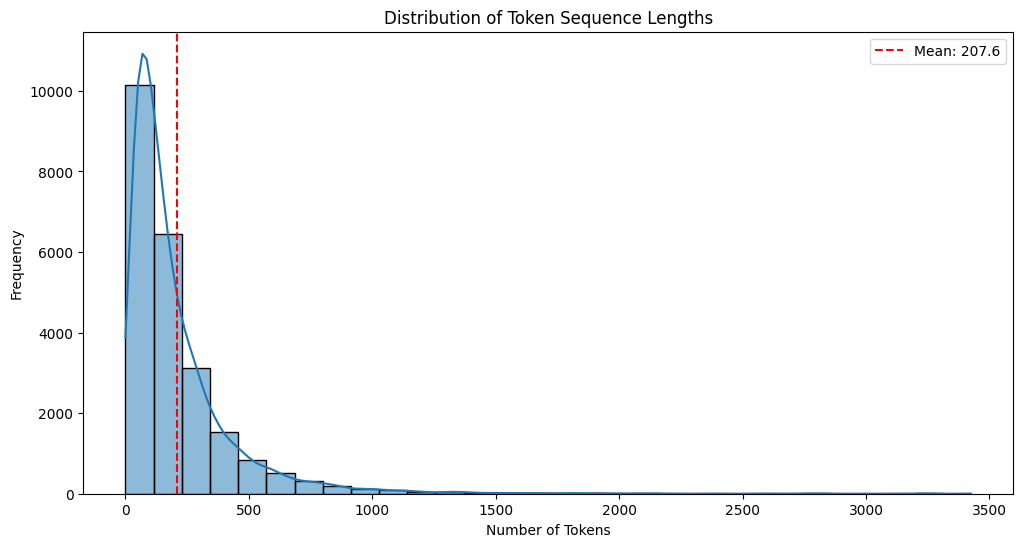

In [25]:
plt.figure(figsize=(12, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Distribution of Token Sequence Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(lengths.mean(), color='r', linestyle='--', label=f'Mean: {lengths.mean():.1f}')
plt.legend()
plt.show()

In [26]:
# only considering the records where the no. of tokens are more than 30  and less than or equal to 500, in order to understand the story of user better.
df_train = df_train[df_train['tokens'].apply(len) > 30]
df_train = df_train[df_train['tokens'].apply(len) <= 500]

In [27]:
df_train

,Text,emotion,cleaned_text,label,tokens
18692,(m20) i just feel so alone. like nobody cares....,sad,feel alone like nobody care even people say al...,7,"[feel, alone, like, nobody, care, even, people..."
20415,"out of 140 applicants, all with business degre...",sad,applicant business degree choose starve artist...,7,"[applicant, business, degree, choose, starve, ..."
16791,i'm so fed up with societies ideals that skinn...,disgusted,feed society ideal skinny people care world tw...,2,"[feed, society, ideal, skinny, people, care, w..."
19036,i ask this question with all seriousness. what...,sad,ask question seriousness hug feel like never e...,7,"[ask, question, seriousness, hug, feel, like, ..."
27837,"by that i mean, really, truly love them? i hav...",neutral,mean really truly love great family supportive...,5,"[mean, really, truly, love, great, family, sup..."
...,...,...,...,...,...
23955,today i realized that i'm an addict. i have no...,happy,today realize addict control even though ive c...,4,"[today, realize, addict, control, even, though..."
4797,"just for info, i'm female. i absolutely hated ...",regret,info female absolutely hat school diagnose adh...,6,"[info, female, absolutely, hat, school, diagno..."
23665,me (23f) and my older brother (26m) are best f...,happy,f old brother best friend close anything talk ...,4,"[f, old, brother, best, friend, close, anythin..."
4562,throwaway. i know all the reasons why i should...,regret,throwaway know reason watch movie read story t...,6,"[throwaway, know, reason, watch, movie, read, ..."


In [ ]:
# lets create our vocabulary on our own
from collections import Counter

# count word frequencies from training tokens
counter = Counter()
for tokens in df_train['tokens']:
    counter.update(tokens)

# defining special tokens
special_tokens = ['<pad>' , '<unk>']

vocab = {word : idx+len(special_tokens)  for idx , (word , _) in enumerate(counter.most_common())}
vocab['<pad>'] = 0
vocab['<unk>'] = 1


In [38]:
# saving the vocab
import json

with open("vocab.json" , "w") as file:
    json.dump(vocab , file)

In [ ]:
# import the vocab
import json
with open("vocab.json", "r") as file:
    vocab = json.load(file)

# Convert values from string to int (JSON converts all to string)
vocab = {key: int(val) for key, val in vocab.items()}


In [32]:
import torch

In [33]:
def get_index(tokens , vocab):
    return torch.tensor([vocab.get(token , vocab['<unk>']) for token in tokens])


In [34]:
# lets convert the word of sentence to indices

indexed_train = [get_index(tokens , vocab) for tokens in df_train['tokens']]
indexed_test = [get_index(tokens , vocab) for tokens in df_test['tokens']]

indexed_test[5]

tensor([  427,   868,     3,   550,   134,   231,    16,   866,   111,  7103,
          354,   231,  4066,    25,   676,     8,     4,   284,     5,   710,
            2,    34,     2,    38,    34,  1471,     2,    92,   646,    13,
          407,   231,    36,   187,  8012,  6927,   712, 10427, 10777,   182,
        20225,   232,   454,  1503,   888,   269,  2530,    17,    13,    18,
           62,  1740,    17,    33,    12,    61,  7861,  1503,   888,   181,
            8,  2947,     4,  7508,   983,  1169,  6192,   432,   419,   120,
           18,   192,   242,   231,  1558,  1503,  1503,   888,  1326,  5392,
         1013,    30,   320,     4,  7508,   109,   320,    97,    61,   367,
            5,  1303,   223,  1169,   758,     2,   441,   862,   547,   172,
          181,     8,   144,   320,    97,    99,    31,   162,    42,  2284,
            3,   144,   547,   320,    39,   162,     4,  7508,   397,    92,
         2135,  4378,   547,   128,    17,     5,    99,    31, 

In [35]:
# now lets add the padding
from torch.nn.utils.rnn import pad_sequence

padded_train = pad_sequence(indexed_train , batch_first=True , padding_value=vocab['<pad>'])
padded_test = pad_sequence(indexed_test , batch_first=True , padding_value=vocab['<pad>'])


In [36]:
print(padded_train[0])
print(padded_train[0].shape)

tensor([    7,   160,     4,   459,    86,    19,    11,    10,    48,  3808,
         1370,    54,  1119,     7,     4, 12170,    20,  2399,     7,     4,
          442,    35,   331,  4641,  1207,   180,  5788,  1338,  1477,  1411,
          380,   445,    13,    94,    26,     2,   506,  2286,     7,    19,
         1380,    59,    35,    72,  6357,    20,     7,     4,  1400,    48,
         1400,    76,   800,  1227,   132,   434,   152,   535,  1400,    38,
           21,    45,    20,   217,    24,    27,   114,    66,   100,    26,
           35,   277,   122,   152,   835,  2414,  2063,   169,    26,   484,
           16,   104,   130,  1172,   167,   265,   169,    42,  5027,   767,
            8,   670,  1090,  1029,   756,    26,   355,   126,   169,   778,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [37]:
# getting the labels
labels_train = torch.tensor(df_train['label'].values)
labels_test = torch.tensor(df_test['label'].values)


In [38]:
labels_train

tensor([7, 7, 2,  ..., 4, 6, 0])

In [39]:
from torch.utils.data import TensorDataset , DataLoader

train_dataset = TensorDataset(padded_train , labels_train)
test_dataset = TensorDataset(padded_test , labels_test)

train_loader = DataLoader(train_dataset , batch_size = 64 , shuffle = True , pin_memory = True , num_workers = 2)
test_laoder = DataLoader(test_dataset , batch_size = 64 , shuffle = True , pin_memory = True  , num_workers = 2)


In [99]:
# define the model
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self , vocab_size , embedding_dim , hidden_dim , output_dim , pad_index , dropout_p = 0.3):
      super().__init__()

      self.embedding = nn.Embedding(vocab_size , embedding_dim , padding_idx=pad_index)
      self.dropout1 = nn.Dropout(dropout_p)
      self.rnn = nn.LSTM(embedding_dim , hidden_dim , batch_first=True , bidirectional=True)
      self.dropout2 = nn.Dropout(dropout_p)
      # The hidden dimension of the linear layer should be 2 * hidden_dim because of the bidirectional LSTM
      self.fc = nn.Linear(hidden_dim * 2 , output_dim)

  def forward(self , x):
    embedded = self.embedding(x)
    embedded = self.dropout1(embedded) # Apply dropout after embedding
    _ , (hidden , _) = self.rnn(embedded)
    # hidden has shape (2, batch_size, hidden_dim) for bidirectional LSTM
    # Concatenate the hidden states from the forward and backward directions
    hidden = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1)
    hidden = self.dropout2(hidden) # Apply dropout before the linear layer
    return self.fc(hidden)

In [100]:
# initialize the model
# The hidden dimension parameter in the model initialization should be half of the actual hidden dimension
# that is passed to the linear layer because of the bidirectional LSTM
model = RNN(len(vocab) , 100 , 128 , len(encoder.classes_) , vocab['<pad>'])

In [101]:
# enabling gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [102]:
print(f"Model is on: {next(model.parameters()).device}")

Model is on: cuda:0


In [103]:
# loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001 , weight_decay=1e-4)

In [104]:
epochs = 30

In [105]:
for epoch in range(epochs):
  model.train()
  total_loss = 0

  for x_batch , y_batch in train_loader:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()

    #forward pass
    output = model(x_batch)

    # calc loss
    loss = criterion(output , y_batch)

    # gradients
    loss.backward()

    # update
    optimizer.step()

    total_loss = total_loss + loss.item()

  print(f"Epoch: {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch: 1, Loss: 2.1265
Epoch: 2, Loss: 2.0327
Epoch: 3, Loss: 2.0688
Epoch: 4, Loss: 1.9027
Epoch: 5, Loss: 1.8889
Epoch: 6, Loss: 1.7936
Epoch: 7, Loss: 1.7060
Epoch: 8, Loss: 1.5983
Epoch: 9, Loss: 1.5286
Epoch: 10, Loss: 1.7333
Epoch: 11, Loss: 1.6994
Epoch: 12, Loss: 1.4953
Epoch: 13, Loss: 1.3989
Epoch: 14, Loss: 1.3981
Epoch: 15, Loss: 1.3573
Epoch: 16, Loss: 1.3045
Epoch: 17, Loss: 1.2218
Epoch: 18, Loss: 1.1240
Epoch: 19, Loss: 1.0433
Epoch: 20, Loss: 0.9663
Epoch: 21, Loss: 0.8830
Epoch: 22, Loss: 0.8201
Epoch: 23, Loss: 0.7593
Epoch: 24, Loss: 0.6867
Epoch: 25, Loss: 0.6162
Epoch: 26, Loss: 0.5555
Epoch: 27, Loss: 0.4946
Epoch: 28, Loss: 0.4384
Epoch: 29, Loss: 0.3935
Epoch: 30, Loss: 0.3518


In [106]:
# lets see how the test set performs
model.eval() # set the model into evaluation mode
total = 0
correct = 0

with torch.no_grad():
  for x_batch , y_batch in test_laoder:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    outputs = model(x_batch)

    _ , predicted = torch.max(outputs , dim=1)  # it returns the max values and their corresponding indices

    total += y_batch.shape[0] # adding the no. of rows which have been tested in 1 batch

    correct += (predicted == y_batch).sum().item()

print(correct)
print(total)
print(f"Validation Accuracy: {correct/total:.4f}")

3645
5884
Validation Accuracy: 0.6195


In [107]:
# evaluation code on training set
total = 0
correct = 0

with torch.no_grad():
    for x_batch , y_batch in train_loader:

      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(x_batch)

      _ , predicted = torch.max(outputs , dim=1)  # it returns the max values and their corresponding indices

      total += y_batch.shape[0] # adding the no. of rows which have been tested in 1 batch

      correct += (predicted == y_batch).sum().item()
print(correct / total)

0.9503584943238399


In [ ]:
# this has been better than previous version , so lets keep it like that and
# do further improvemnets below

In [139]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
# define the model
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self , vocab_size , embedding_dim , hidden_dim , output_dim , pad_index):
      super().__init__()

      self.embedding = nn.Embedding(vocab_size , embedding_dim , padding_idx=pad_index)
      self.dropout1 = nn.Dropout(0.4)
      self.rnn = nn.LSTM(embedding_dim , hidden_dim , batch_first=True , bidirectional=True)
      # self.layer_norm = nn.LayerNorm(hidden_dim * 2)
      self.dropout2 = nn.Dropout(0.4)
      # The hidden dimension of the linear layer should be 2 * hidden_dim because of the bidirectional LSTM
      self.fc = nn.Linear(hidden_dim * 2 , output_dim)

  def forward(self , x):
    embedded = self.embedding(x)
    embedded = self.dropout1(embedded) # Apply dropout after embedding
    _ , (hidden , _) = self.rnn(embedded)
    # hidden has shape (2, batch_size, hidden_dim) for bidirectional LSTM
    # Concatenate the hidden states from the forward and backward directions
    hidden = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1)
    hidden = self.dropout2(hidden) # Apply dropout before the linear layer
    return self.fc(hidden)



# initialize the model
model = RNN(len(vocab) , 100 , 90 , len(encoder.classes_) , vocab['<pad>'])

# enable gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# compute the class weights for imbalanced classes
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# optimizer
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001 , weight_decay=1e-4)


early_stopper = EarlyStopping(patience=5)
epochs = 30


# training loop
for epoch in range(epochs):
  model.train()
  total_loss = 0

  for x_batch , y_batch in train_loader:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()

    #forward pass
    output = model(x_batch)

    # calc loss
    loss = criterion(output , y_batch)

    # gradients
    loss.backward()

    # update
    optimizer.step()

    total_loss = total_loss + loss.item()

  avg_val_loss = total_loss / len(train_loader)

  print(f"Epoch: {epoch+1}, Loss: {avg_val_loss:.4f}")

  early_stopper(avg_val_loss)
  if early_stopper.early_stop:
      print(f"Early stopping triggered at epoch {epoch+1}")
      break


Epoch: 1, Loss: 2.1713
Epoch: 2, Loss: 2.0426
Epoch: 3, Loss: 1.9548
Epoch: 4, Loss: 1.8971
Epoch: 5, Loss: 1.8735
Epoch: 6, Loss: 1.7963
Epoch: 7, Loss: 1.7417
Epoch: 8, Loss: 1.6971
Epoch: 9, Loss: 1.7579
Epoch: 10, Loss: 1.6796
Epoch: 11, Loss: 1.6474
Epoch: 12, Loss: 1.5513
Epoch: 13, Loss: 1.5010
Epoch: 14, Loss: 1.4785
Epoch: 15, Loss: 1.4200
Epoch: 16, Loss: 1.3728
Epoch: 17, Loss: 1.4307
Epoch: 18, Loss: 1.4756
Epoch: 19, Loss: 1.4244
Epoch: 20, Loss: 1.3331
Epoch: 21, Loss: 1.2453
Epoch: 22, Loss: 1.2158
Epoch: 23, Loss: 1.1707
Epoch: 24, Loss: 1.1150
Epoch: 25, Loss: 1.0656
Epoch: 26, Loss: 1.0098
Epoch: 27, Loss: 0.9941
Epoch: 28, Loss: 0.9759
Epoch: 29, Loss: 0.9006
Epoch: 30, Loss: 0.8445


In [151]:
# lets see how the test set performs
model.eval() # set the model into evaluation mode
total = 0
correct = 0

with torch.no_grad():
  for x_batch , y_batch in test_laoder:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    outputs = model(x_batch)

    _ , predicted = torch.max(outputs , dim=1)  # it returns the max values and their corresponding indices

    total += y_batch.shape[0] # adding the no. of rows which have been tested in 1 batch

    correct += (predicted == y_batch).sum().item()

print(correct)
print(total)
print(f"Validation Accuracy: {correct/total:.4f}")

3536
5884
Validation Accuracy: 0.6010


In [152]:
# evaluation code on training set
total = 0
correct = 0

with torch.no_grad():
    for x_batch , y_batch in train_loader:

      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(x_batch)

      _ , predicted = torch.max(outputs , dim=1)  # it returns the max values and their corresponding indices

      total += y_batch.shape[0] # adding the no. of rows which have been tested in 1 batch

      correct += (predicted == y_batch).sum().item()
print(correct / total)

0.7636924915355506


In [153]:
# saving the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss
}, 'emotion_rnn_checkpoint.pth')

In [154]:
# saving the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [156]:
# saving metadata like max_len and min_len of our tensor
import json
with open('meta.json', 'w') as file:
  json.dump({"min_len" : 31 , "max_len" : 500} , file)